# Voting Classifier

We create a voting classifier as a combination of three different classifiers. Each classifier is trained independently of the other. The voting classifier then picks the prediction with the highest probability.

In [182]:
from math import floor, factorial
from decimal import Context, Decimal
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## The maths behind the voting classifier's success

A voting classifier often performs significantly better than each of the individual classifiers that it uses. We can understand this by looking at the following analogy:

Consider a biased coin with probability $p$ of hitting one side of the coin and $(1-p)$ of hitting the other side. We toss the coin $n$ times. On average, we will end up with $n\cdot p$ heads and $n\cdot (1-p)$ tails.

In [4]:
n = 1000
p = 51/100
print("We get {} heads and {} tails on average.".format(int(n*p), int(n*(1-p))))

We get 510 heads and 490 tails on average.


If we consider each coin flip to be an independent classifier, then the performance would not be very good as we can see from the calculation above. We can combine the "classifiers" however. Instead of looking at each individual coin toss, we calculate the probability that after $n$ tosses, we end up with a **majority** of one of the two sides (e.g. heads). This probability is given by a sum over the binomial distribution:

In [142]:
def calc_prob(n, p):
    prob = 0
    m = int(floor(n/2 + 1))
    ctx = Context()
    for i in range(m, n + 1):
        binomFact = factorial(n)//factorial(n-i)//factorial(i)
        binomDistr = Decimal(100)*Decimal(binomFact)*ctx.power(Decimal(p), Decimal(i))*ctx.power(Decimal(1-p), Decimal(n-i))
        prob += round(binomDistr, 2)
    print("The probability for a biased coin (p={} for heads) for ending up with a majority of heads after {} tosses is {}%.".format(p, n, round(prob, 2)))

In [146]:
n = 1000
p = 51/100
calc_prob(n, p)

The probability for a biased coin (p=0.51 for heads) for ending up with a majority of heads after 1000 tosses is 72.62%.


In [145]:
n = 10000
p = 51/100
calc_prob(n, p)

The probability for a biased coin (p=0.51 for heads) for ending up with a majority of heads after 10000 tosses is 97.60%.


So we observe that if we toss a biased coin (with $p=0.51$ for heads) a $n=1000$ times, we have a 72.6% chance of observing a majority of heads. For $n=10000$, the chance is already as high as 97.6%! If we use all of the $n$ tosses and combine them into one voting classifier, we pick the target class (heads, in this case) with high probability. This is the reason why voting classifiers (i.e., ensemble classifiers) can work very well even if the individual classifier does not perform that well.

## Load some dummy data

We again use the moon dataset to create some dummy data for our classification.

In [169]:
X, y = make_moons(n_samples=100, noise=0.14)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Plot the training data

In [194]:
x_circ_1 = []
y_circ_1 = []
x_circ_2 = []
y_circ_2 = []
for i in range(len(y_train)):
    if y_train[i] == 0:
        x_circ_1.append(X_train[i][0])
        y_circ_1.append(X_train[i][1])
    else:
        x_circ_2.append(X_train[i][0])
        y_circ_2.append(X_train[i][1])

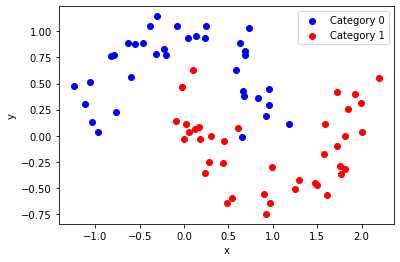

In [195]:
plt.scatter(x_circ_1, y_circ_1, c='b', label='Category 0')
plt.scatter(x_circ_2, y_circ_2, c='r', label='Category 1')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Scale the data

In [196]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Implementation of a voting classifier

We consider a voting classifier which consists of three different classifiers:<br>
- a logistic regression classifier
- a random forest classifier
- a support vector classifier

In [223]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [207]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [224]:
y_predict = voting_clf.predict(X_test_scaled)
print(voting_clf.__class__.__name__, accuracy_score(y_test, y_predict))
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_scaled, y_train)
    y_predict = clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test, y_predict))

VotingClassifier 0.92
LogisticRegression 0.84
RandomForestClassifier 0.92
SVC 0.96
VotingClassifier 0.92


## Increase performance by switching to soft voting

In [219]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

In [220]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [222]:
y_predict = voting_clf.predict(X_test_scaled)
print(voting_clf.__class__.__name__, accuracy_score(y_test, y_predict))
for clf in (log_clf, rnd_clf, svm_clf):
    clf.fit(X_train_scaled, y_train)
    y_predict = clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test, y_predict))

VotingClassifier 0.92
LogisticRegression 0.84
RandomForestClassifier 0.92
SVC 0.96
